In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sys; sys.path.append('../')
import torch
from functools import singledispatch, wraps
from inspect import getcallargs
from scipy.spatial.distance import cdist
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from asterism.base import buildmethod, checkmethod, Asterism
from asterism.utils import get_kwargs, kmeans, relabel
from asterism.utils.acts import Dirichlet
from asterism.utils.data import make_dataset
from asterism.utils.nets import ACT, OPTIM, Encoder, MLP, RNN
from asterism.utils.figs import show_dataset

In [481]:
class RNN(nn.Module):
    def __init__(self, channels, bias=True, act_layer='tanh'):
        super().__init__()

        self.channels = channels
        
        self._model = MLP.layer(self.channels, self.channels, bias, act_layer=act_layer)
        self._x = torch.rand(1, channels)

    def forward(self, n_passes=1, x=None):
        if x is None:
            x = self._x

        for i in range(1, n_passes):
            x = torch.cat([x, self._model(x[i - 1:i])])

        return x
    
class RSB(Asterism, nn.Module):
    def __init__(self, min_topics=2, *, channels=(64, 32), topic_rate=.2, kld_scale=.1, optim='adam', desc='RSB', seed=None):
        super().__init__(desc, seed)

        self.min_topics = min_topics
        self.channels = channels
        self.topic_rate = topic_rate
        self.kld_scale = kld_scale
        self.optim = optim

        self._n_steps = 1000

    def _build(self, X, fit_rate=1e-2, batch_size=128, shuffle=True):
        if batch_size is None:
            batch_size = X.shape[0]

        in_channels, self.n_topics_ = X.shape[-1], self.min_topics
        self._loader = DataLoader(X, batch_size, shuffle)
        self._encoder = Encoder(in_channels, *self.channels, act_layer='prelu')
        self._dt_model = RNN(self.channels[-1], bias=False, act_layer='prelu')
        self._tw_model = RNN(self.channels[-1], bias=False, act_layer='prelu')
        self._decoder = MLP.layer(self.channels[-1], in_channels, bias=False)
        self._optim = OPTIM[self.optim](self.parameters(), lr=fit_rate)
        self.train()

        return self
    
    def _generate(self, z=None, n_topics=None):
        if n_topics is None:
            n_topics = self.n_topics_

        tw_probs = self._decoder(self._tw_model(n_topics))

        if z is not None:
            dt_probs = F.softmax(z@self._dt_model(n_topics).T, -1)
            X = dt_probs@tw_probs

            return X
        return tw_probs
    
    def _evaluate(self, X):
        z, kld = self._encoder(X, return_kld=True)
        Xk, XK = self._generate(z, self.n_topics_ - 1), self._generate(z)
        lossk = (Xk - X).square().sum(-1)/X.shape[0]
        lossK = (XK - X).square().sum(-1)/X.shape[0]

        if (lossk - lossK).sum()/lossK.sum() > self.topic_rate:
            self.n_topics_ += 1

        loss = lossK.sum() + self.kld_scale*kld

        return loss
    
    def _step(self):
        loss = 0.

        for x in self._loader:
            x_loss = self._evaluate(x)
            x_loss.backward()
            loss += x_loss.item()

        self._optim.step()
        self._optim.zero_grad()

        return loss
    
    def _predict(self, X, eval=True):
        if eval:
            self.eval()

        topics = (X@self._generate().T).argmax(-1).detach()

        return topics

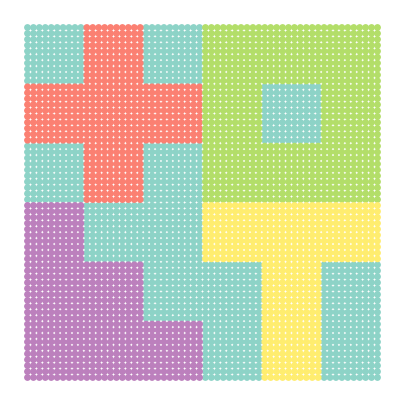

In [8]:
data, labels = make_dataset(return_tensor=True)
show_dataset(data, labels)

In [9]:
from asterism.models.ntm import RSB

RSB: 100%|██████████| 1000/1000 [00:23<00:00, 42.77it/s]


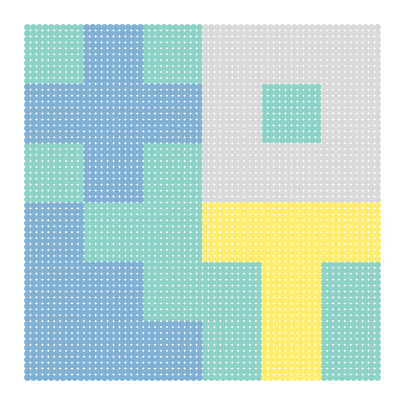

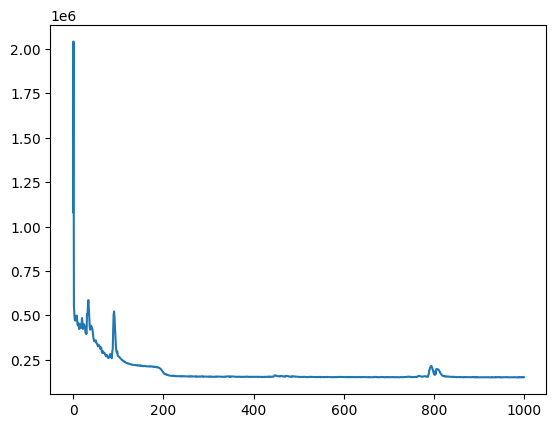

In [10]:
model = RSB()
topics = model.fit_predict(data[:, 3:], learn_rate=1e-2)
show_dataset(data, topics)
plt.plot(range(len(model.log_)), model.log_)
plt.show()

In [2]:
import numpy as np

In [3]:
np.max([1, 2])

np.int64(2)

In [5]:
np.arange(10).max(1, keepdim=True)

TypeError: _amax() got an unexpected keyword argument 'keepdim'. Did you mean 'keepdims'?